In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

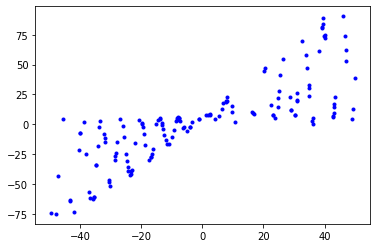

In [7]:
k = 1
b = 5
x_min = -50
x_max = 50

n = 150

def aleatoric(x): # variablity function for a particular x
  r = (x - x_min) / (x_max - x_min)
  return 2 * r

def generate_data(n):
  x = (x_max - x_min) * np.random.rand(n) + x_min 
  noise = np.random.randn(n) * aleatoric(x)
  y = (k * x * (1 + np.sin(x)) + b) + noise   # add some non-linearity and noise
  x = x[..., np.newaxis] # convert to N * 1 matrix
  return x, y

x_train, y_train = generate_data(n)
x_test, y_test = generate_data(n)

plt.figure()
plt.plot(x_train, y_train, "b.")

In [8]:
# Make posterior/prior function

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc =t[..., :n],
                     scale = 0.2 + tf.nn.softplus(c + t[..., n:])),
                     #scale = 200 + tf.nn.softplus(c + t[..., n:])), # for experimenting
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# To use `bias_size=0` when these are passed to `tfp.layers.DenseVariational`
# also pass `use_bias=False` to `tfp.layers.DenseVariational`

The prior and likelihood specification 

- $p(\theta) = MVN(\theta_0,I)$ with $f(\theta_0) \propto 1$
- $p(y|\theta,x) = N(\beta_0 + \beta_1 x, 3)$ with $\theta = (\beta_0, \beta_1)$

admit posterior approximation using [*mean-field* *variational inference*](https://math.stackexchange.com/questions/308149/what-is-the-meaning-of-mean-field) with

- $q(\theta) = N( \theta',\text{diag}(\sigma'))$ with $f( \theta', \sigma') \propto 1$ 
  - which minimizes $ KL [ \;q(\theta) \;|| \;p(\theta|y) \;]$
  - i.e., which  approximates $p(\theta|y)$ with $q(\theta)$

where the *mean-field* descriptor simply indicates the independent specification of $q(\theta)$.

The equation from which *variational inference* generally arises may be simply derived as

$
\begin{align*}
\log p(y) = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + KL[\, q(\theta) \, || \, p(\theta|y) \,]  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$

and should be viewed as the precise manifestation of a relatively intuitive expectation about a decomposition of $\log p(y)$ using $E_{q(\theta)}[\log p(y|\theta)]$; namely,
the injection of the alien term $q(\theta) \approx p(\theta|y)$ is not coherrent with the probability structure $p(y,\theta)$ but by appropriatly triangulating $p(\theta), p(\theta|y),$ and $q(\theta)$, adjusted values of $q(\theta)$ may be brought into coherrence with $p(y,\theta)$. Specifically, this is done with 

1. a correction factor for the approximation $q(\theta) \approx p(\theta|y)$ itself
  - which disappears if $q(\theta)$ perfectly approximates $p(\theta|y)$
  - but in general means $E_{p(\theta|y)}[\log p(y|\theta)] \not = E_{q(\theta)}[\log p(y|\theta)]$

2. a correction factor for wrongly integrating over $q(\theta) \approx p(\theta|y) \not = p(\theta)$
  - since $\log p(y) = E_{p(\theta)}[\log p(y|\theta)] \not =  E_{p(\theta|y)}[\log p(y|\theta)].$

> The triangulation is necessary because the pairwise relationships are not enough to coherently resolve $q(\theta)$ with $p(y,\theta)$.
- E.g., $E_{p(\theta|y)}[\log p(y|\theta)]$ cannot be generally derived from 
$E_{q(\theta)}[\log p(y|\theta)]$ and the KL-divergence term $KL[\, q(\theta) \, || \, p(\theta|y) \,]$; rather,
- it is the interplay of the prior and posterior KL-divergence terms which allows $\log p(y) = E_{p(\theta)}[\log p(y|\theta)]$ to be resolved in terms of $E_{q(\theta)}[\log p(y|\theta)]$.

*Variational inference* notes that since the marginal likelihood is a fixed value

$$\log p(y) = E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,] + KL[\, q(\theta) \, || \, p(\theta|y) \,] $$

smaller values for $KL[\, q(\theta) \, || \, p(\theta|y) \,]$, i.e., 
better approximations $q(\theta)$ of $p(\theta|y)$ will result in a balance between
- larger the expected log likelihood under $q(\theta)$: $E_{q(\theta)}[\log p(y|\theta)]$
- smaller difference between $q(\theta)$ and $p(\theta)$: $KL[\, q(\theta) \, || \, p(\theta) \,]$

Thus the objectives

$$\min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \quad \text{ and } \quad \max_q E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]$$

are equivalent.

> *Variational inference* is often alternatively derived in terms of the Evidence Lower BOund, i.e., the ELBO$(q)$, using Jensen's inequality
>
> $$
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right]  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\geq {} & E_{q(\theta)}\left[ \log p(y,\theta)\frac{1}{q(\theta)} \right] &={} & E_{q(\theta)}\left[ \log p(y|\theta)\frac{p(\theta)}{q(\theta)} \right] \\
= {} & \underbrace{E_{q(\theta)}[ \log p(y,\theta)] - E_{q(\theta)}[ \log q(\theta)]}_{\text{ELBO}(q)} &={} & \underbrace{E_{q(\theta)}[ \log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q)}
\end{align*}
$$
>
> and can be expressed in terms of only expectations or include a KL-divergence term.  Using the latter version, since this was previously derived above, Jensen's inequality guarantees that the marginal likelihood, i.e., the "Evidence", will have the *Lower BOund*
>
> $$\log p(y) \geq \text{ELBO}(q) = E_{q(\theta)}[ \log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]$$
>
> where, from the first equality derived above, the discrepancy can be seen to be $KL[\, q(\theta) \, || \, p(\theta|y) \,]$. Thus, again,
>
> $$\max_q \text{ELBO}(q) \quad \text{ is equivalent to } \quad \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,]$$
> which justifies pursuing $\text{ELBO}(q)$ as the objective for the purposes of *variational inference*.

> Another, sort of "reverse" approach to this derivation is to begin with the approximation
> 
> $$
\begin{align*}
KL[\, q(\theta) \, || \,  p(\theta|y) \, ] = {} & \int \log \frac{q(\theta)}{p(\theta|y)}q(\theta)d\theta\\
= {} & \int \log \frac{q(\theta)p(y)}{p(y|\theta)p(\theta)}q(\theta) d\theta\\
= {} & \log p(y) + \int \log \frac{q(\theta)}{p(\theta)}q(\theta) d\theta - \int \log p(y|\theta) q(\theta) d\theta \\
= {} & \log p(y) + \overbrace{\underbrace{KL[\, q(\theta) \, || \,  p(\theta) \, ]}_{\text{minimize positive number}} \underbrace{- \int \log p(y|\theta) q(\theta) d\theta}_{\text{maximize log lik. under $q(\theta)$}}}^{\text{negative Evidence Lower BOund for $q(\theta)$, i.e., $-$ELBO$(q)$}} \\
\end{align*}
$$
>
> and notice that 
> - the ELBO$(q)$ inequality derives from the fact that the initial KL-divergence term must be non-negative. 
> - to minimize the righthand side (and hence lefthand side) the objective function is
>
> $$\min_q - \text{ELBO}(q) \quad \text{ which is equivalent to } \quad \max_q \text{ELBO}(q)$$

It is this final derivation which can be seen in the specification below as

- from the [documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational), the `call` and `_make_kl_divergence_penalty` functions defined in the [source code](https://github.com/tensorflow/probability/blob/v0.13.0/tensorflow_probability/python/layers/dense_variational_v2.py#L26-L145) indicate that when a `DenseVariational` layer is passed input

  0. it intantiates a distributional layer of posterior distributions, regardless of the input batch size

    ```
# Line 121: q = self._posterior(inputs) 
DVL = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, 
                                       kl_weight=1/x_train.shape[0])
batch_size=10
DVL(np.array(batch_size*[[0.]])) # initialize `call(.)`
DVL._posterior(np.array(batch_size*[[0.]])) 
# size 2 since this includes beta_0 and \beta_1 (offset b and weight w)
    ```

  1. It calculates KL-divergence either exactly or "approximately" using a single sample from  $q(\theta)$, i.e.,

   $$KL[\, q(\theta) \, || \,  p(\theta) \, ] = \int log \frac{q(\theta)}{p(\theta)} q(\theta) d \theta \quad \text{ or } \quad KL[\, q(\theta) \, || \,  p(\theta) \, ] \approx log \frac{q(\theta^*)}{p(\theta^*)}, \text{with } \theta^* \sim q(\theta)$$

   depending on the setting of `use_exact_kl=[True|False]`, and adds it to the model loss

    ```
# 123: self.add_loss(self._kl_divergence_fn(q, r))
# where `self._kl_divergence_fn(q, r)` is either
# 156: kl_divergence_fn = kullback_leibler.kl_divergence
# or `def kl_divergence_fn(distribution_a, distribution_b)` as
# 151: test_points_fn=tf.convert_to_tensor
# 159: z = test_points_fn(distribution_a)
# 161: distribution_a.log_prob(z) - distribution_b.log_prob(z)
tf.convert_to_tensor(DVL._posterior(np.array(batch_size*[[0.]])))
    ```

  2. It actualizes a layer of weights as single sample observations from the distributional layer of posterior distributions

    ```
# 125: w = tf.convert_to_tensor(value=q)
# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda
# defines `convert_to_tensor_fn=tfp.distributions.Distribution.sample`
# replace  `scale = 0.2 + ...` with `scale = 200 + ...` in posterior_mean_field
# and see if `w*input+b` is based on `posterior_mean_field` or `prior_trainable`
DVL = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, 
                                  kl_weight=1/x_train.shape[0])
DVL(np.array(batch_size*[[0.]]))
    ```

In [9]:
# `kl_weight=1/n` is wrong; but, this will be addressed and corrected below
model3 = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,
                              kl_weight=1/n), # use_bias=False
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], scale=3)) # constant variance
])
# To use the `bias_size=0` default of `posterior_mean_field` and `prior_trainable`
# `use_bias=False` must be passed to `tfp.layers.DenseVariational`
# otherwise `bias_size=units` (first argument) will be passed forward and used

def negloglik(y, py):
  return -py.log_prob(y)
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)

# https://keras.io/api/losses/#the-addloss-api
# - `loss=negloglik` is different from the model's `.losses` attribute
# - `.losses` attributes include additional loss terms, e.g., KL-divergence 
# "These losses are cleared by the top-level layer at the start of each forward pass"
# "So layer.losses always contain only the losses created during the last forward pass."
# However, this `TrackLosses` definition, then, does not work as expected
# https://www.tensorflow.org/guide/keras/custom_callback#usage_of_selfmodel_attribute
class TrackLosses(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs={}):
        print(self.model.losses)
# This callback lets us see "loss" calcualations for each back
# where "loss" now means `loss=negloglik` + `.losses` so to speak
loss_callback = tf.keras.callbacks.LambdaCallback( 
  on_batch_end=lambda batch,logs: 
  print("\nbatch "+str(batch) + ": " + str(logs["loss"]), end='\n'*(batch==4))
)

# `y_train[:, np.newaxis]` rather than `y_train` because
# `negloglik(y_train[:, np.newaxis], model3(x_train))` works
# `negloglik(y_train, model3(x_train))` does not work
model3.fit(x_train, y_train[:, np.newaxis], 
           validation_data=(x_train, y_train[:, np.newaxis]),
           epochs=1, verbose=True, 
           callbacks=[loss_callback, TrackLosses()])
# regarding default `batch_size=None` the documentation says 
# "if unspecified, batch_size will default to 32."

1/5 [=====>........................] - ETA: 3s - loss: 105.5667
batch 0: 105.56666564941406[<tf.Tensor 'sequential/dense_variational/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

batch 1: 111.70921325683594[<tf.Tensor 'sequential/dense_variational/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

batch 2: 124.49939727783203[<tf.Tensor 'sequential/dense_variational/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

batch 3: 107.1360092163086[<tf.Tensor 'sequential/dense_variational/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

batch 4: 99.61274719238281
[<tf.Tensor 'sequential/dense_variational/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]
5/5 [==============================] - 1s 69ms/step - loss: 99.6127 - val_loss: 72.4990


In [10]:
# loss is actually being retained as average loss
negloglik(y_train[:,np.newaxis], model3(x_train)).numpy().mean(), negloglik(y_train[:,np.newaxis], model3(x_train)).numpy().sum()

(305.72635, 19306.125)

In [11]:
# the losses is only filled out when model is called externally to `.fit`
model3.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0029499992>]

In [59]:
# To gain access to both `loss=negloglik` and `.losses` terms
# we slightly modify the default training code
# https://github.com/keras-team/keras/blob/master/keras/engine/training.py#L753
# https://keras.io/guides/customizing_what_happens_in_fit/

loss_tracker = tf.keras.metrics.Mean(name="loss")
nll_tracker = tf.keras.metrics.Mean(name="negloglike")
KL_tracker = tf.keras.metrics.Mean(name="KL-div")
class ModelPrintingLosses(tf.keras.Model):

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be
    # called automatically at the start of each epoch
    # or at the start of `evaluate()`.
    # If you don't implement this property, you have to call
    # `reset_states()` yourself at the time of your choosing.
    return [loss_tracker, nll_tracker, KL_tracker]

  def train_step(self, data):
    x, y = data # `sample_weight` removed
    # Run forward pass.
    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses) # `sample_weight` remove

    if self.loss and y is None:
      raise TypeError(
          f'Target data is missing. Your model has `loss`: {self.loss}, '
          'and therefore expects target data to be passed in `fit()`.')
    # Run backwards pass.
    self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    #self.compiled_metrics.update_state(y, y_pred) # `sample_weight` removed
    
    # these will return running averages, reset for each new epoch
    nll = self.loss(y, y_pred)
    nll_tracker.update_state(nll)
    kld = self.losses[0]
    KL_tracker.update_state(kld)
    loss_tracker.update_state(tf.reduce_mean(nll)+kld)
    # so while the batch calculations sum, the running averages need not

    # Collect metrics to return
    return_metrics = {}
    for metric in self.metrics:
      result = metric.result()
      if isinstance(result, dict):
        return_metrics.update(result)
      else:
        return_metrics[metric.name] = result
    return return_metrics

When performing gradient descent with an epoch of $j=1,\cdots, J$ batches, the features $x_j$ of the $j^{th}$ batch $(x_j,y_j)$ 
1. are input to the `DenseVariational` layer, resulting in a single exact or approximate calculation of $KL[\, q(\theta) \, || \,  p(\theta) \, ]$ then weighted by `kl_weight` and then stored in the model's `self.losses`
2. then multiplied through the `DenseVariational` layer actualized with a sample from $\theta_j^* \sim q(\theta)$ of the distributions of the layer 
3. subsequently defining $p(y_j|\theta_j^*,x_j)$ which when evaluated on the outcomes $y_j$ gives the negative log likelihood of the samples in batch $j$ for the $\theta_j^*$ instantiated for batch $j$
  - and the average negative log likelihoods for all samples in batch $j$ is calculated with `tf.reduce_mean` applied to `loss=negloklik`, and this is then added to the (previously `kl_weight`'ed) `self.losses`
  - and a gradient descent step is made on this basis of this loss for batch $j$.

Under this framework the objective 

$$\min_q -E_{q(\theta)}[\log p(y|\theta,x)] + KL[\, q(\theta) \, || \, p(\theta) \,]$$

is thus approximated with the loss for batch $j$ which is the summation of 

1. a "single draw" Monte Carlo estimate of $-\frac{1}{n_j}E_{q(\theta)}[\log p(y|\theta)]$ for batch $j$
  - $\displaystyle -  \sum_{i=1}^{n_j} \frac{1}{n_j} \log p(y_{ij}|\theta_j^*,x_{ij}) \; \text{ where } \; \theta_j^* \sim p(\theta) \; \text{ and } \; \frac{1}{n_j} \approx \frac{J}{n}$
2. and one $KL[\, q(\theta) \, || \, p(\theta) \,]$ term to be weighted by `kl_weight`
  - which requires a `kl_weight` of $\frac{1}{n_j} \approx \frac{J}{n}$ so that it is appropriately proportionally represented relative to $-\frac{1}{n_j}E_{q(\theta)}[\log p(y|\theta)]$ with respect to the objective function of interest.

This issue is correctly noted here: 
https://github.com/tensorflow/probability/issues/396#issuecomment-537492051

In [60]:
# regarding default `batch_size=None` the documentation says 
# "if unspecified, batch_size will default to 32."
J = int(n/32) + int((n%32)>0)
model3 = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,
                              kl_weight=J/n), # use_bias=False
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], scale=3)) # constant variance
])

loss_callback = tf.keras.callbacks.LambdaCallback( 
  on_batch_end=lambda batch,logs: 
  print("\nbatch "+str(batch) + ": " + str(np.float32(logs["loss"])) +
        ": " + str(np.float32(logs["negloglike"])) +
        ": " + str(np.float32(logs["KL-div"])), end='\n'*(batch==4))
)

input = tf.keras.layers.Input(shape=(1,))
model3 = ModelPrintingLosses(input, model3(input))
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model3.fit(x_train, y_train[:, np.newaxis], 
           epochs=10, verbose=True, 
           callbacks=[loss_callback])

Epoch 1/10
1/5 [=====>........................] - ETA: 2s - loss: 247.6707 - negloglike: 247.6755 - KL-div: -0.0048
batch 0: 247.6707: 247.67554: -0.004841948
batch 1: 381.73282: 381.73425: -0.0014423769
batch 2: 261.45255: 261.45523: -0.0027145732
batch 3: 210.09172: 210.096: -0.004279083
batch 4: 189.44397: 194.94687: 0.005882173
5/5 [==============================] - 1s 3ms/step - loss: 189.4440 - negloglike: 194.9469 - KL-div: 0.0059
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 470.6747 - negloglike: 470.6927 - KL-div: -0.0181
batch 0: 470.67465: 470.69275: -0.018098084
batch 1: 279.73163: 279.72943: 0.0022159657
batch 2: 248.09465: 248.10156: -0.006896941
batch 3: 204.7993: 204.80399: -0.00466102
batch 4: 242.86954: 232.72563: -0.009390461
5/5 [==============================] - 0s 4ms/step - loss: 242.8695 - negloglike: 232.7256 - KL-div: -0.0094
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 32.6664 - negloglike: 32.6566 - KL-div: 0.0098
ba

In [61]:
model3.fit(x_train, y_train[:, np.newaxis], epochs=100, verbose=False)

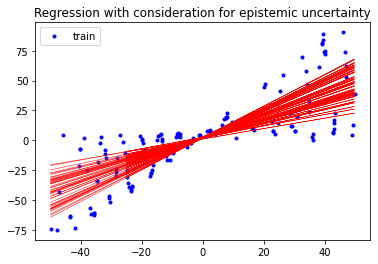

In [62]:
plt.figure()
plt.plot(x_train, y_train, 'b.', label="train")
for i in range(50):
  pred = model3(x_test)
  plt.plot(x_test, pred.mean(), 'r', linewidth=0.5)
plt.title("Regression with consideration for epistemic uncertainty")
plt.legend()
plt.show()